# Pneumonia Detection from Chest X-Ray Images
### This project uses a Convolutional Neural Network (CNN) to detect **Pneumonia** from chest X-ray images

## Imports and Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Preparation

In [2]:
train_path = '../Treci projekat/chest_xray/train'
test_path = '../Treci projekat/chest_xray/test'
valid_path = '../Treci projekat/chest_xray/val'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input, rotation_range = 15, width_shift_range=0.1,
    height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True) \
    .flow_from_directory(directory = train_path, target_size = (224,224), classes = ['Normal','Pneumonia'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = test_path, target_size = (224,224), classes = ['Normal','Pneumonia'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['Normal','Pneumonia'], batch_size = 10, shuffle = False)

Found 5152 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [4]:
assert train_batches.n == 5152
assert test_batches.n == 624
assert valid_batches.n == 80

## Image Visualization

In [5]:
imgs, labels = next(train_batches)

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize= (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        img = np.clip(img, 0, 255).astype(np.uint8)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

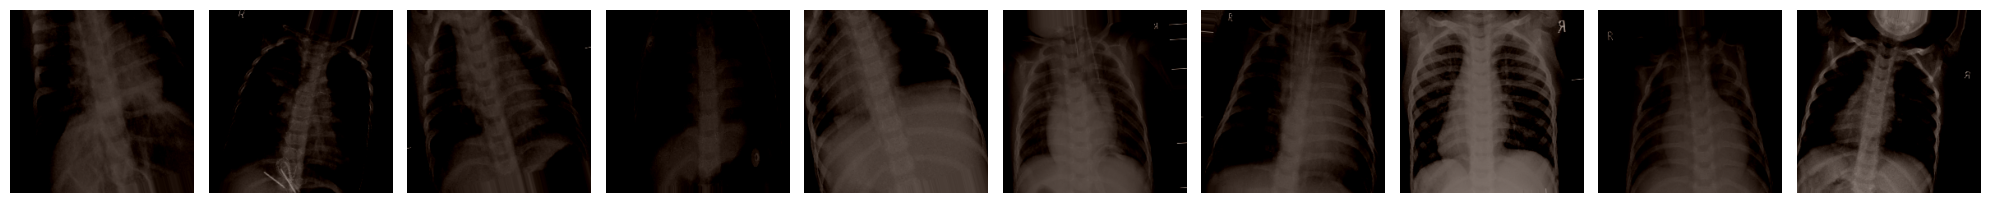

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [7]:
plotImages(imgs)
print(labels)

## CNN Model Aechitecture and Compiling

In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation = 'relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## Model Training

In [9]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
fiting = model.fit(
    train_batches,
    validation_data = valid_batches,
    epochs = 15,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 245s 472ms/step - accuracy: 0.8210 - loss: 5.2021 - val_accuracy: 0.8875 - val_loss: 0.3657
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 240s 465ms/step - accuracy: 0.9128 - loss: 0.2196 - val_accuracy: 0.8875 - val_loss: 0.3318
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 240s 465ms/step - accuracy: 0.9408 - loss: 0.1671 - val_accuracy: 0.9000 - val_loss: 0.2303
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 224s 433ms/step - accuracy: 0.9327 - loss: 0.1787 - val_accuracy: 0.8875 - val_loss: 0.2100
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 217s 421ms/step - accuracy: 0.9411 - loss: 0.1588 - val_accuracy: 0.8875 - val_loss: 0.2179
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 224s 434ms/step - accuracy: 0.9425 - loss: 0.1551 - val_accuracy: 0.8750 - val_loss: 0.3620
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 221s 428ms/step - accuracy: 0.9446 - loss: 0.1476 - val_accuracy: 0.9000 - val_loss: 0.2427


## Model Evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8259 - loss: 0.4760
Test accuracy: 0.8317
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step


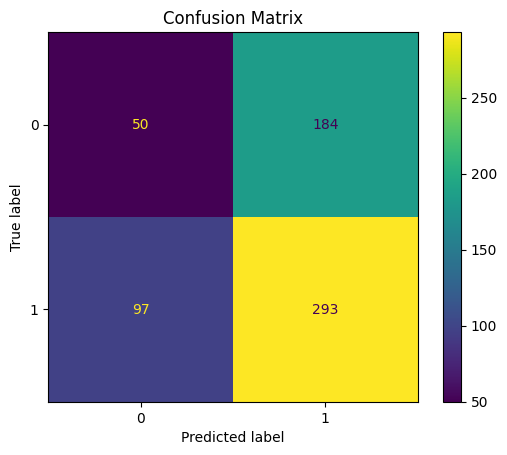

              precision    recall  f1-score   support

      NORMAL       0.34      0.21      0.26       234
   PNEUMONIA       0.61      0.75      0.68       390

    accuracy                           0.55       624
   macro avg       0.48      0.48      0.47       624
weighted avg       0.51      0.55      0.52       624



In [10]:
test_loss, test_acc = model.evaluate(test_batches)
print(f"Test accuracy: {test_acc:.4f}")

y_pred = model.predict(test_batches)
y_pred = np.argmax(y_pred, axis = 1)
y_true = test_batches.classes

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_true, y_pred, target_names = ['NORMAL', 'PNEUMONIA']))

## Saving the Model

In [11]:
model.save('pneumonia_model.keras')